In [18]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add the repo root to the Python path
sys.path.append(repo_root)

# Now you can import from src
from src.master.data import load_and_crop_data
from src.master.visualize import visualize_masks
from src.master.evaluate import evaluate_binary_masks
from src.master.model import (
    RandomForestClassifier, KNNClassifier, LogRegClassifier, SVMClassifier,
    CLIPEmbedding, HoGEmbedding, ResNET18Embedding
)

In [19]:
from src.master.data import KFoldSegmentationManager

# Define the dataset path
dataset_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/sam_inference/processed_data/meatballs"

# Create dataset manager for this specific dataset
dataset_manager = KFoldSegmentationManager(
    dataset_path=dataset_path,
    class_id=1
)

# Print dataset information
print(f"Dataset info: {dataset_manager.get_dataset_info()}")

# Get 5-fold cross validation dataloaders
folds = dataset_manager.get_kfold_dataloaders(k=5, batch_size=1)

# Example: Using with your embedding-classifier framework
print("\nTraining example with first fold:")
train_loader, val_loader = folds[0]

# Get training data directly in the format for classifier.fit()
train_images, train_masks, train_labels = dataset_manager.get_training_data(train_loader)

print(f"Training data prepared:")
print(f"  Images: {len(train_images)}")
print(f"  Shape: {train_images[0].shape}")
print(f"  GT masks: {len(train_masks)}")
print(f"  Shape: {train_masks[0][0].shape}")
print(f"  Labels: {len(train_labels)}")
print(f"  Sample: {train_labels[0]}")


Dataset info: {'dataset_name': 'meatballs', 'class_id': 1, 'total_samples': 200}

Training example with first fold:
Training data prepared:
  Images: 40
  Shape: (270, 250, 3)
  GT masks: 40
  Shape: (270, 250)
  Labels: 40
  Sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


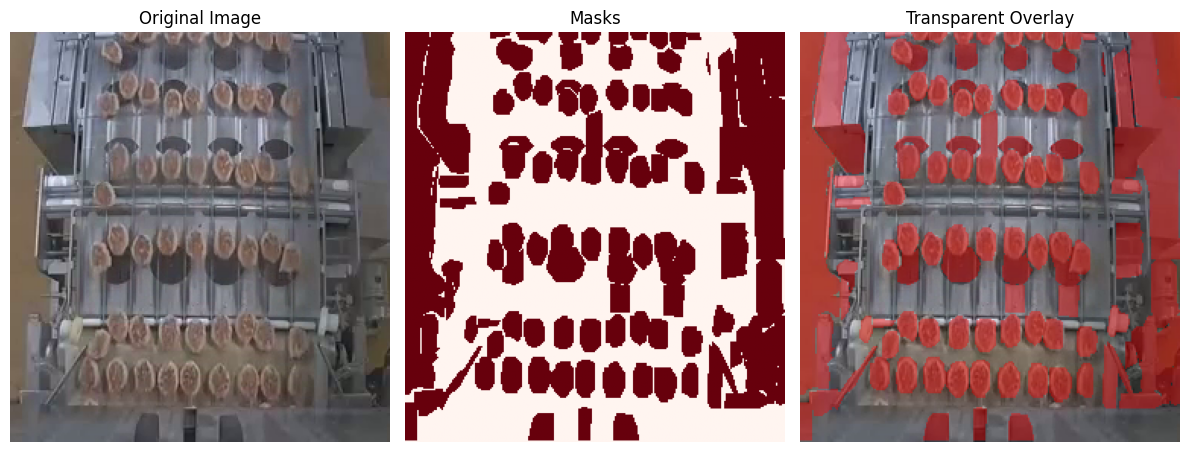

In [20]:
visualize_masks(train_images[0], train_masks[0])

In [21]:
# 1. Create embedding and classifier
config = {
    'clip_model': 'ViT-B/32',
    'use_PCA': True,
    'PCA_var': 0.95
}
embedding = CLIPEmbedding(config)
classifier = KNNClassifier(config, embedding)



Using device: cpu


In [22]:
# 2. Train classifier directly with the data
classifier.fit(train_images, train_masks, train_labels)

Reduced feature dimension from 512 to 100 with 95.0% variance preserved


True

(270, 250, 3)
270


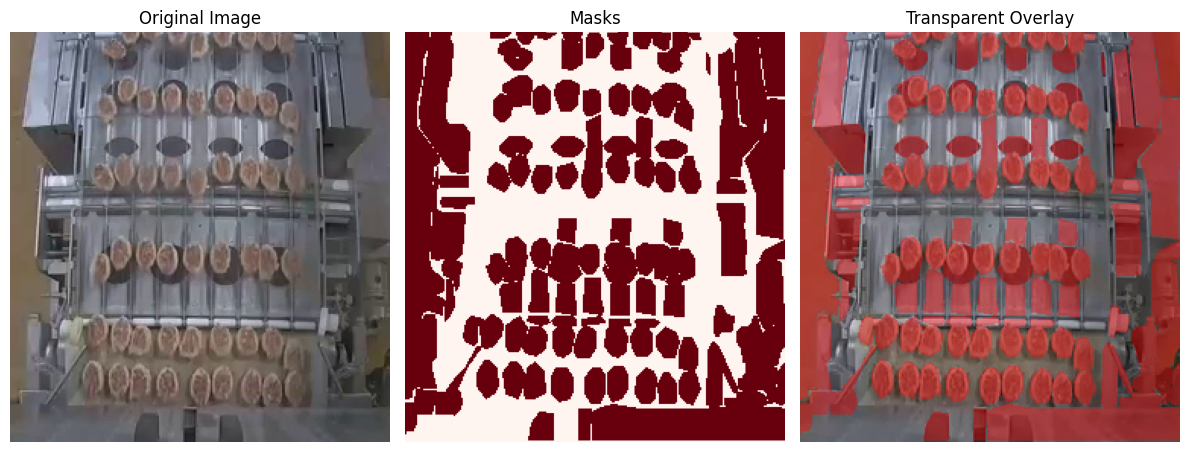

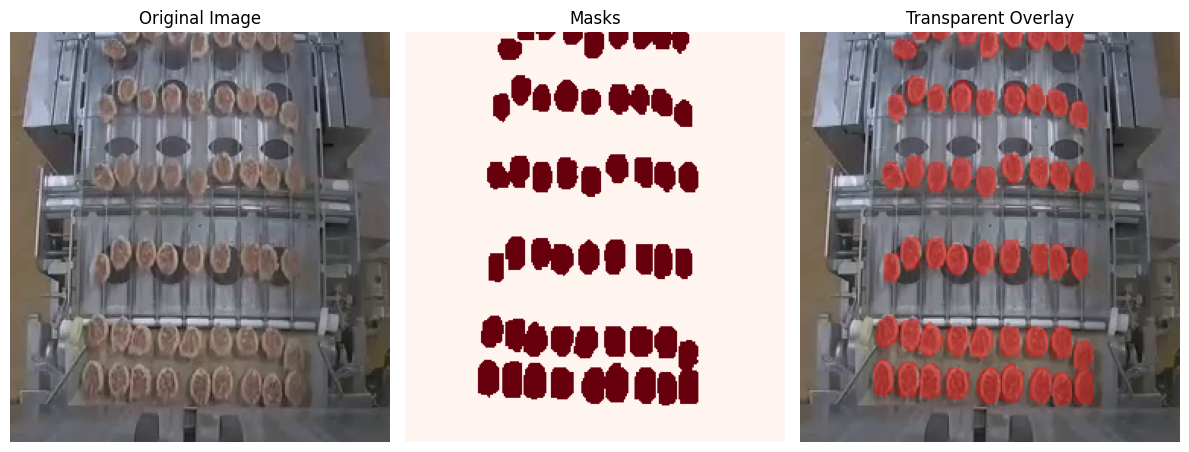

In [23]:
# 3. Get validation data for prediction
validation_data = dataset_manager.get_prediction_data(val_loader)

print(validation_data[0][0].shape)
print(len(validation_data[0][0]))

img, sam, gt = validation_data[0]


visualize_masks(img, sam)
visualize_masks(img, gt)

In [24]:
import numpy as np

def evaluate_binary_masks_fast(gt_masks, pred_masks, iou_threshold=0.5):
    """
    Optimized version of evaluate_binary_masks for better performance.
    
    Parameters:
    -----------
    gt_masks : list of np.ndarray
        List of ground truth binary masks (0 or 1)
    pred_masks : list of np.ndarray
        List of predicted binary masks (0 or 1)
    iou_threshold : float, optional
        IoU threshold to consider a mask as successfully detected (default: 0.5)
        
    Returns:
    --------
    dict
        Dictionary with evaluation metrics
    """
    total_gt_masks = len(gt_masks)
    total_pred_masks = len(pred_masks)
    
    # Early return for empty cases
    if total_gt_masks == 0 or total_pred_masks == 0:
        return {
            'mask_precision': 0 if total_pred_masks > 0 else 1.0,  # Precision is 1.0 if no predictions (no false positives)
            'mask_recall': 0 if total_gt_masks > 0 else 1.0,       # Recall is 1.0 if no ground truth (no false negatives)
            'mask_f1': 0,
            'detected_masks': 0,
            'total_gt_masks': total_gt_masks,
            'total_pred_masks': total_pred_masks,
            'avg_iou_detected': 0,
            'avg_iou_all': 0,
            'best_ious': []
        }
    
    # Pre-compute binary masks once
    gt_binary = [(mask > 0).astype(np.uint8) for mask in gt_masks]
    pred_binary = [(mask > 0).astype(np.uint8) for mask in pred_masks]
    
    # Create IoU matrix more efficiently
    iou_matrix = np.zeros((total_gt_masks, total_pred_masks))
    
    # Optimize IoU calculation with vectorization where possible
    for i, gt in enumerate(gt_binary):
        gt_sum = gt.sum()  # Pre-compute sum of GT mask
        if gt_sum == 0:
            continue  # Skip empty GT masks
            
        for j, pred in enumerate(pred_binary):
            # Use fast bitwise operations
            intersection = np.logical_and(gt, pred).sum()
            if intersection == 0:
                continue  # Skip if no intersection (IoU will be 0)
                
            # Union = sum of both masks - intersection
            pred_sum = pred.sum()  # Pre-compute sum of pred mask
            union = gt_sum + pred_sum - intersection
            
            iou_matrix[i, j] = intersection / union if union > 0 else 0
    
    # Process the IoU matrix with numpy operations
    best_ious = np.max(iou_matrix, axis=1)
    detected_mask_indices = best_ious >= iou_threshold
    detected_masks = np.sum(detected_mask_indices)
    
    # Calculate precision, recall, F1
    true_positives = detected_masks
    false_negatives = total_gt_masks - detected_masks
    false_positives = total_pred_masks - detected_masks
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate average IoU statistics
    avg_iou_detected = np.mean(best_ious[detected_mask_indices]) if np.any(detected_mask_indices) else 0
    avg_iou_all = np.mean(best_ious)
    
    # Create metrics dictionary
    metrics = {
        'mask_precision': precision,
        'mask_recall': recall,
        'mask_f1': f1,
        'detected_masks': int(detected_masks),
        'total_gt_masks': total_gt_masks,
        'total_pred_masks': total_pred_masks,
        'avg_iou_detected': avg_iou_detected,
        'avg_iou_all': avg_iou_all,
        'best_ious': best_ious.tolist()  # Convert to list for JSON serialization
    }
    
    return metrics

In [25]:
import numpy as np
from tqdm import tqdm  # Import tqdm for progress monitoring

# 4. Evaluate on validation data
results_all = []
for image, candidate_masks, gt_masks in tqdm(validation_data, desc="Evaluating"):
    # Predict with classifier
    results_with_classes, probs = classifier.predict(
        image, 
        candidate_masks, 
        return_probabilities=True
    )
    
    # Unpack the results to get just the masks (without the class labels)
    # Assuming results is a list of (mask, class) tuples
    # And we only want masks where class is 1 (positive)
    positive_masks = [mask for mask, class_label in results_with_classes if class_label == 1]
    
    # Now evaluate using just the positive masks
    metrics = evaluate_binary_masks_fast(gt_masks, positive_masks)
    results_all.append(metrics['mask_f1'])

# After the loop, you can calculate overall statistics
mean_f1 = np.mean(results_all)
print(f"Mean F1 score: {mean_f1:.4f}")




Evaluating: 100%|██████████| 160/160 [34:51<00:00, 13.07s/it]

Mean F1 score: 0.9562


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

# Add the parent directory to path so we can import the report generator
sys.path.append('.')

# Import the report generator - update this to match your import path
from src.master.report_generator import SegmentationReportGenerator

# Create a directory for testing
test_output_dir = "pipeline_comparison_test"
os.makedirs(test_output_dir, exist_ok=True)

# Create mock dataset managers with only 3 datasets
class MockDatasetManager:
    def __init__(self, name, total_samples, class_id):
        self.name = name
        self.total_samples = total_samples
        self.class_id = class_id
        
    def get_dataset_info(self):
        return {
            "total_samples": self.total_samples,
            "class_id": self.class_id
        }

# Create 3 mock dataset managers
dataset_managers = {
    "ShapeNet": MockDatasetManager("ShapeNet", 100, 1),
    "PASCAL": MockDatasetManager("PASCAL", 150, 2),
    "COCO": MockDatasetManager("COCO", 200, 3)
}

# Define 3 embeddings and 3 classifiers
embeddings = ["CLIP", "ResNet18", "DinoV2"]
classifiers = ["SVM", "KNN", "RF"]
datasets = list(dataset_managers.keys())

# Create comprehensive mock results for ideal track (with full recall / perfect masks)
ideal_results = {}

for dataset in datasets:
    ideal_results[dataset] = {}
    
    for embedding in embeddings:
        ideal_results[dataset][embedding] = {}
        
        for classifier in classifiers:
            # Skip some combinations to make it more realistic
            if classifier == "RF" and embedding == "DinoV2":
                continue
            if classifier == "KNN" and embedding == "ResNet18":
                continue
                
            # Generate F1 scores for ideal track (generally higher)
            base_f1 = np.random.uniform(0.75, 0.95)
            
            ideal_results[dataset][embedding][classifier] = {
                "mask_precision": round(base_f1 + np.random.uniform(0.01, 0.03), 4),
                "mask_recall": round(base_f1 - np.random.uniform(0.01, 0.03), 4),
                "mask_f1": round(base_f1, 4),
                "avg_iou_detected": round(base_f1 - 0.05, 4),
                "detected_masks": int(dataset_managers[dataset].total_samples * 0.85),
                "total_gt_masks": dataset_managers[dataset].total_samples,
                "avg_training_time": round(np.random.uniform(0.5, 4.0), 2),
                "avg_inference_time": round(np.random.uniform(0.1, 0.6), 2)
            }

# Create mock results for realistic track (with SAM2-generated masks)
realistic_results = {}

for dataset in datasets:
    realistic_results[dataset] = {}
    
    for embedding in embeddings:
        realistic_results[dataset][embedding] = {}
        
        for classifier in classifiers:
            # Skip the same combinations as in ideal track
            if classifier == "RF" and embedding == "DinoV2":
                continue
            if classifier == "KNN" and embedding == "ResNet18":
                continue
                
            # Get ideal F1 score if it exists
            ideal_f1 = 0
            if (dataset in ideal_results and 
                embedding in ideal_results[dataset] and 
                classifier in ideal_results[dataset][embedding]):
                ideal_f1 = ideal_results[dataset][embedding][classifier]["mask_f1"]
            else:
                ideal_f1 = np.random.uniform(0.75, 0.95)
            
            # Generate F1 scores for realistic track (lower than ideal)
            # The gap represents SAM2's imperfection
            sam2_error = np.random.uniform(0.05, 0.15)  # Random SAM2 error
            realistic_f1 = ideal_f1 - sam2_error
            
            realistic_results[dataset][embedding][classifier] = {
                "mask_precision": round(realistic_f1 + np.random.uniform(0.01, 0.03), 4),
                "mask_recall": round(realistic_f1 - np.random.uniform(0.01, 0.03), 4),
                "mask_f1": round(realistic_f1, 4),
                "avg_iou_detected": round(realistic_f1 - 0.05, 4),
                "detected_masks": int(dataset_managers[dataset].total_samples * 0.7),
                "total_gt_masks": dataset_managers[dataset].total_samples,
                "avg_training_time": round(np.random.uniform(0.5, 4.0), 2),
                "avg_inference_time": round(np.random.uniform(0.1, 0.6), 2)
            }

# Combine results format for full report generation
all_results = {
    "per_dataset": realistic_results
}

# Create some simple training size data
all_results["training_size"] = {}
train_sizes = [2, 5, 10, 20, 50]

for dataset in datasets:
    all_results["training_size"][dataset] = {}
    
    for embedding in embeddings:
        all_results["training_size"][dataset][embedding] = {}
        
        for classifier in classifiers:
            # Skip same combinations
            if classifier == "RF" and embedding == "DinoV2":
                continue
            if classifier == "KNN" and embedding == "ResNet18":
                continue
                
            all_results["training_size"][dataset][embedding][classifier] = {}
            
            # Get max F1 from realistic results
            max_f1 = 0
            if (dataset in realistic_results and 
                embedding in realistic_results[dataset] and 
                classifier in realistic_results[dataset][embedding]):
                max_f1 = realistic_results[dataset][embedding][classifier]["mask_f1"]
            else:
                max_f1 = np.random.uniform(0.6, 0.8)
            
            # Generate learning curve
            base_f1 = np.random.uniform(0.3, 0.5)
            growth_rate = np.random.uniform(0.1, 0.3)
            
            for size in train_sizes:
                f1 = max_f1 - (max_f1 - base_f1) * np.exp(-growth_rate * size / 10)
                f1 = min(max_f1, f1 + np.random.uniform(-0.02, 0.02))
                
                all_results["training_size"][dataset][embedding][classifier][str(size)] = {
                    "mask_f1": round(f1, 4),
                    "mask_precision": round(f1 + np.random.uniform(0.01, 0.03), 4),
                    "mask_recall": round(f1 - np.random.uniform(0.01, 0.03), 4)
                }

# Create learning_curves directory
learning_curves_dir = os.path.join(test_output_dir, 'learning_curves')
os.makedirs(learning_curves_dir, exist_ok=True)

# Create report generator and generate report
report_generator = SegmentationReportGenerator(test_output_dir)
summary_df = report_generator.generate_full_report(all_results, dataset_managers)

print(f"Report generated in {test_output_dir}")

# Add rank stability analysis
model_stability = report_generator.analyze_model_rank_stability(summary_df)
report_generator.plot_rank_stability(model_stability)
report_generator.add_rank_stability_section(model_stability)

print("Added rank stability analysis")

# Add pipeline comparison
report_generator.add_pipeline_comparison(ideal_results, realistic_results)

print("Added pipeline comparison")
print(f"\nOpen {test_output_dir}/ablation_report.html to view the full report")

Report generated in pipeline_comparison_test
Added rank stability analysis
Added pipeline comparison

Open pipeline_comparison_test/ablation_report.html to view the full report


<Figure size 1500x1000 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>